In [1]:
import pandas as pd
import numpy as np

experiments = {
    'tests/selective_pressure/standard': 'standard',
    'tests/selective_pressure/p10': 'p10',
    'tests/selective_pressure/p8': 'p8',
    'tests/selective_pressure/p6': 'p6',
    'tests/selective_pressure/p4': 'p4',
    'tests/selective_pressure/p2': 'p2',
    'p0': 'best-curriculum',
}

seeds = [f's{i}' for i in range(1, 11)]
stats = {}
tests = []
fits = []

base_dir = '../../datalake/ppsn'

for experiment, title in experiments.items():
    stats_data = f'{base_dir}/{experiment}/data/xdpole/runstats'
    stats[experiment] = {}
    for seed in seeds:
        seed_stats = pd.read_csv(f'{stats_data}/{seed}_run.csv')
        gens = seed_stats.gen.max()
        seed_test = pd.read_csv(f'{stats_data}/{seed}_test.csv')
        tests.append(dict(
            seed=seed,
            experiment=title,
            score=seed_test.score[0],
            generations=gens
        ))
        fits.append(dict(
            seed=seed,
            experiment=title,
            generations=gens,
            bestgfit=seed_stats.bestgfit.max()
        ))
        stats[experiment][seed] = seed_stats

Text(0.5, 0, '')

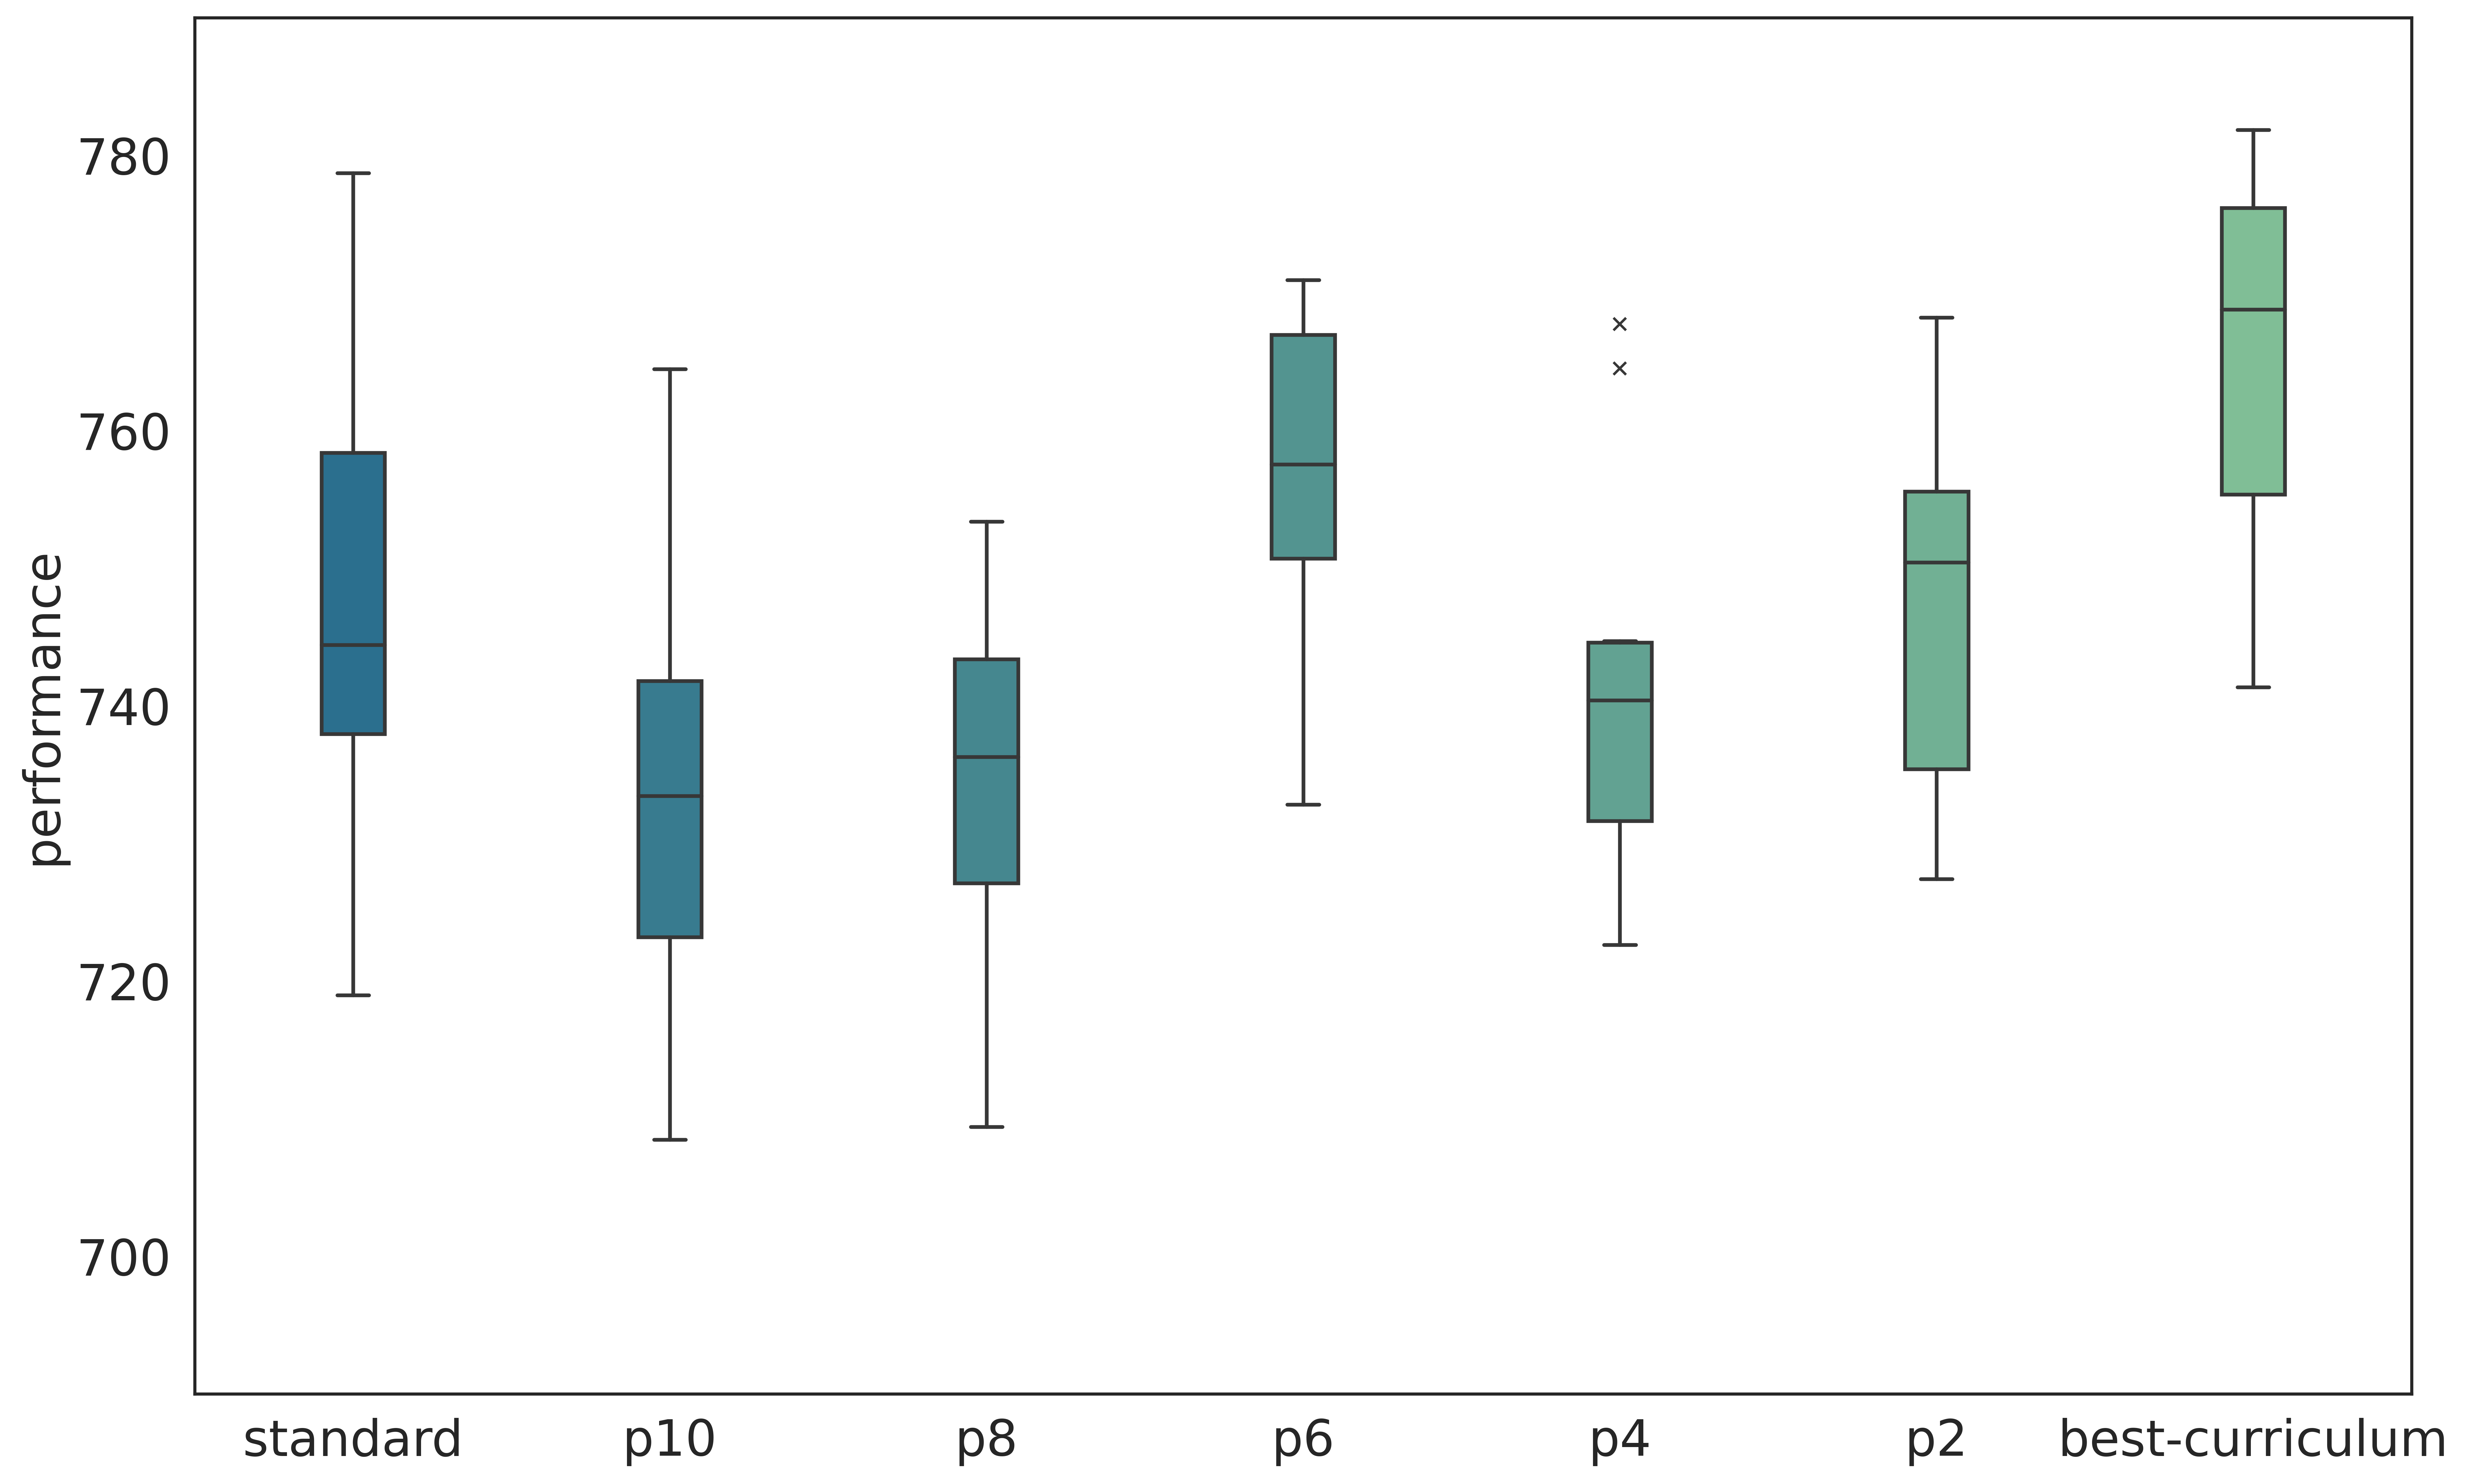

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set(rc={'figure.figsize':(16,10)}, style='white')

palette = 'blend:#1a759f,#76c893'
df = pd.DataFrame(tests)
plt.figure(dpi=600)
sns.boxplot(df, x='experiment', y='score', width=0.2, flierprops={"marker": "x"}, palette=palette)
plt.ylabel("performance", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylim([690,790])
plt.xlabel("")

In [3]:
mean_stats = pd.DataFrame()

maxmsteps = 10000
palette = 'blend:#1a759f,#76c893'

for experiment, title in experiments.items():
    experiment_stats = stats[experiment]

    seeds_df = pd.DataFrame()
    for seed in seeds:
        seed_df = experiment_stats[seed]
        df = pd.DataFrame()
        df['progress'] = [i/maxmsteps for i in range(maxmsteps)]
        
        bestgfits = seed_df.bestgfit.unique()
        mmsteps = []
        for bestgfit in bestgfits:
            msteps = seed_df[seed_df["bestgfit"] == bestgfit].msteps.max()
            mmsteps.append(msteps)

        performance = []
        idx = 0
        bgf = bestgfits[idx]
        for i in range(maxmsteps):
            if i > mmsteps[idx]:
                idx += 1
                bgf = bestgfits[idx]
            performance.append(bgf)

        df['performance'] = performance
        df['seed'] = seed

        seeds_df = pd.concat([seeds_df, df], ignore_index=True) if not seeds_df.empty else df

    seeds_df['experiment'] = title
    mean_stats = pd.concat([mean_stats, seeds_df], ignore_index=True) if not mean_stats.empty else seeds_df